In [1]:
import cv2
import matplotlib.pyplot as plt
from preprocess_images import apply_circular_mask, process_for_stopping_criteria
import numpy as np
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn

In [2]:
def to_square(img, t_x, t_y, b_x, b_y):
    h, w = img.shape[:2]
    m_x = w//2 + b_x
    m_y = h//2 + b_y
    return img[m_y-t_y//2:m_y+t_y//2,m_x-t_x//2:m_x+t_x//2]  

def high_pass(img, t):
    new = np.copy(img)
    new[img<t] = 0
    return new

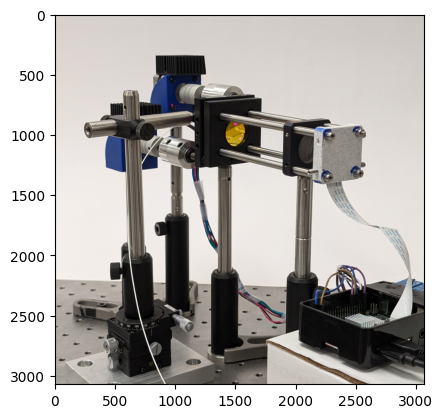

In [6]:
color_img = cv2.imread("/mnt/c/Users/EVV13/Pictures/sysphoto-hires.jpg", cv2.IMREAD_COLOR_RGB)
r = min(*color_img.shape[:2])
plt.imshow(to_square(color_img, r, r, 0, 0))

In [3]:
def apply_circular_mask(image_array, radius):
    """Applies a circular mask that blackens everything outside a centered circle."""
    h, w = image_array.shape[:2]
    center = (w // 2, h // 2)

    # Create a black mask with a white circle in the center
    mask = np.zeros((h, w), dtype=np.uint8)
    mask = cv2.circle(mask, center, radius, 255, -1)

    result = np.zeros_like(image_array)
    result[mask == 255] = image_array[mask == 255]

    return result

# Histogram Equalization

In [4]:
dark_path = "/mnt/h/latest_real_data/real_data/real/x0.00_y0.00.jpg"
lamp_path = "/mnt/h/latest_real_data/light/x0.00_y0.00.jpg"
light_path = "/mnt/h/newlight/main_light/x0.00_y0.00.jpg"

skewed_dark_path = "/mnt/h/latest_real_data/real_data/real/x1.00_y0.50.jpg"
skewed_lamp_path = "/mnt/h/latest_real_data/light/x1.00_y0.50.jpg"
skewed_light_path = "/mnt/h/newlight/main_light/x1.00_y0.50.jpg"

scatter_dark_path = "/mnt/h/latest_real_data/real_data/real/x1.12_y-1.16.jpg"
scatter_lamp_path = "/mnt/h/latest_real_data/light/x1.12_y-1.16.jpg"
scatter_light_path = "/mnt/h/newlight/main_light/x1.12_y-1.16.jpg"

dark = cv2.imread(dark_path, cv2.IMREAD_GRAYSCALE)
lamp = cv2.imread(lamp_path, cv2.IMREAD_GRAYSCALE)
light = cv2.imread(light_path, cv2.IMREAD_GRAYSCALE)

skewed_dark = cv2.imread(skewed_dark_path, cv2.IMREAD_GRAYSCALE)
skewed_lamp = cv2.imread(skewed_lamp_path, cv2.IMREAD_GRAYSCALE)
skewed_light = cv2.imread(skewed_light_path, cv2.IMREAD_GRAYSCALE)

scatter_dark = cv2.imread(scatter_dark_path, cv2.IMREAD_GRAYSCALE)
scatter_lamp = cv2.imread(scatter_lamp_path, cv2.IMREAD_GRAYSCALE)
scatter_light = cv2.imread(scatter_light_path, cv2.IMREAD_GRAYSCALE)

Original zero


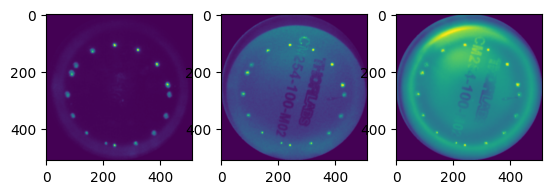

In [5]:
fig, axes = plt.subplots(1,3)
print("Original zero")
axes[0].imshow(dark)
axes[1].imshow(lamp)
axes[2].imshow(light)
plt.show()

Original skewed


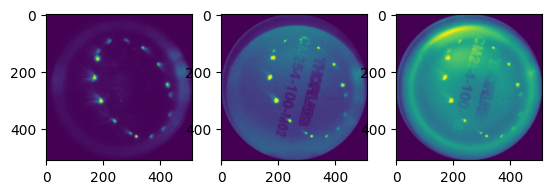

In [6]:
fig, axes = plt.subplots(1,3)
print("Original skewed")
axes[0].imshow(skewed_dark)
axes[1].imshow(skewed_lamp)
axes[2].imshow(skewed_light)
plt.show()

Original scatter


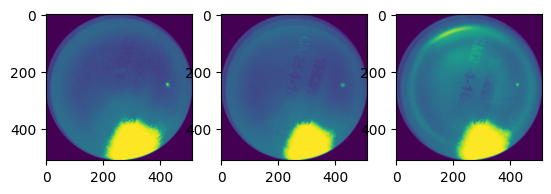

In [7]:
fig, axes = plt.subplots(1,3)
print("Original scatter")
axes[0].imshow(scatter_dark)
axes[1].imshow(scatter_lamp)
axes[2].imshow(scatter_light)
plt.show()

equalizeHist


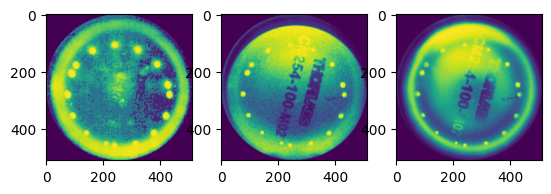

In [8]:
eqdark = cv2.equalizeHist(np.copy(dark))
eqlamp = cv2.equalizeHist(np.copy(lamp))
eqlight = cv2.equalizeHist(np.copy(light))

fig, axes = plt.subplots(1,3)
print("equalizeHist")
axes[0].imshow(eqdark)
axes[1].imshow(eqlamp)
axes[2].imshow(eqlight)
plt.show()

CLAHE


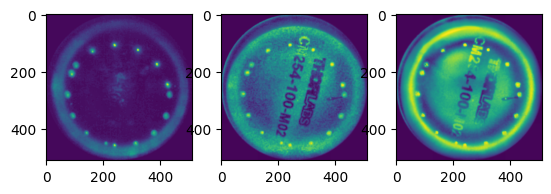

In [9]:
clahe = cv2.createCLAHE(clipLimit=5)
aeqdark = clahe.apply(np.copy(dark))
aeqlamp = clahe.apply(np.copy(lamp))
aeqlight = clahe.apply(np.copy(light))

fig, axes = plt.subplots(1,3)
print("CLAHE")
axes[0].imshow(aeqdark)
axes[1].imshow(aeqlamp)
axes[2].imshow(aeqlight)
plt.show()

In [10]:
def grad(gray):
    gray = cv2.GaussianBlur(gray, (15,15), 5)
    gX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    gY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    # the gradient magnitude images are now of the floating point data
    # type, so we need to take care to convert them back a to unsigned
    # 8-bit integer representation so other OpenCV functions can operate
    # on them and visualize them
    gX = cv2.convertScaleAbs(gX)
    gY = cv2.convertScaleAbs(gY)
    # combine the gradient representations into a single image
    return cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

grad


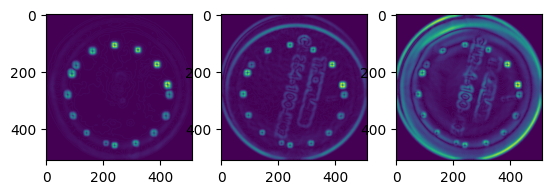

In [11]:
grad_dark = grad(np.copy(dark))
grad_lamp = grad(np.copy(lamp))
grad_light = grad(np.copy(light))

fig, axes = plt.subplots(1,3)
print("grad")
axes[0].imshow(grad_dark)
axes[1].imshow(grad_lamp)
axes[2].imshow(grad_light)
plt.show()

In [12]:
def clahegrad(input, lim = 0.001, ksize=(15,15), sigma=5, t=15):
    img = np.copy(input)
    img = high_pass(img, t)
    clahe = cv2.createCLAHE(clipLimit=lim)
    img = clahe.apply(img)
    img = cv2.GaussianBlur(img, ksize, sigma)
    gX = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    gY = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    
    gX = cv2.convertScaleAbs(gX)
    gY = cv2.convertScaleAbs(gY)
    img = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
    img = apply_circular_mask(img, 250)
    # img = clahe.apply(img)
    return img

clahe grad


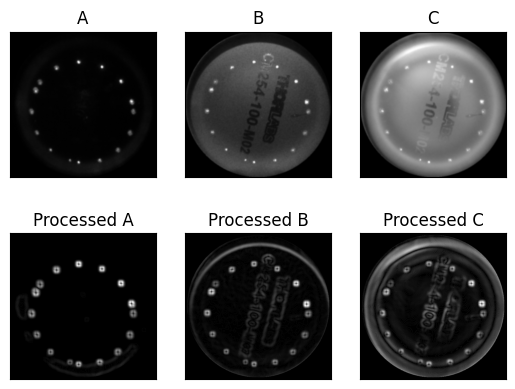

In [13]:
grad_aeqdark = clahegrad(dark)
grad_aeqlamp = clahegrad(lamp)
grad_aeqlight = clahegrad(light)

fig, axes = plt.subplots(2,3)
print("clahe grad")
axes[0][0].imshow(dark, cmap='gray')
axes[0][1].imshow(lamp, cmap='gray')
axes[0][2].imshow(light, cmap='gray')
axes[1][0].imshow(grad_aeqdark, cmap='gray')
axes[1][1].imshow(grad_aeqlamp, cmap='gray')
axes[1][2].imshow(grad_aeqlight, cmap='gray')
axes[0][0].set_title("A")
axes[0][1].set_title("B")
axes[0][2].set_title("C")
axes[1][0].set_title("Processed A")
axes[1][1].set_title("Processed B")
axes[1][2].set_title("Processed C")

for i in range(2):
    for j in range(3):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.show()
fig.savefig("graphs/clahe_processing_zero.png", dpi=300, transparent=True)

clahe grad


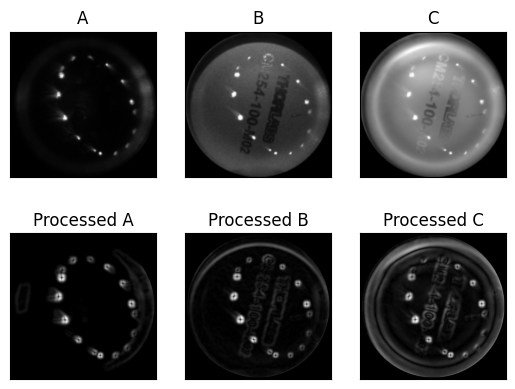

In [14]:
grad_aeqdark_skewed = clahegrad(skewed_dark)
grad_aeqlamp_skewed = clahegrad(skewed_lamp)
grad_aeqlight_skewed = clahegrad(skewed_light)

fig, axes = plt.subplots(2,3)
print("clahe grad")
axes[0][0].imshow(skewed_dark, cmap='gray')
axes[0][1].imshow(skewed_lamp, cmap='gray')
axes[0][2].imshow(skewed_light, cmap='gray')
axes[1][0].imshow(grad_aeqdark_skewed, cmap='gray')
axes[1][1].imshow(grad_aeqlamp_skewed, cmap='gray')
axes[1][2].imshow(grad_aeqlight_skewed, cmap='gray')
axes[0][0].set_title("A")
axes[0][1].set_title("B")
axes[0][2].set_title("C")
axes[1][0].set_title("Processed A")
axes[1][1].set_title("Processed B")
axes[1][2].set_title("Processed C")

for i in range(2):
    for j in range(3):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.show()
fig.savefig("graphs/clahe_processing_skewed.png", dpi=300, transparent=True)

clahe grad


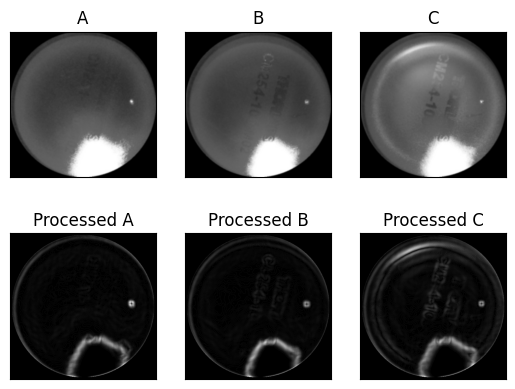

In [15]:
grad_aeqdark_scatter = clahegrad(scatter_dark)
grad_aeqlamp_scatter = clahegrad(scatter_lamp)
grad_aeqlight_scatter = clahegrad(scatter_light)

fig, axes = plt.subplots(2,3)
print("clahe grad")
axes[0][0].imshow(scatter_dark, cmap='gray')
axes[0][1].imshow(scatter_lamp, cmap='gray')
axes[0][2].imshow(scatter_light, cmap='gray')
axes[1][0].imshow(grad_aeqdark_scatter, cmap='gray')
axes[1][1].imshow(grad_aeqlamp_scatter, cmap='gray')
axes[1][2].imshow(grad_aeqlight_scatter, cmap='gray')
axes[0][0].set_title("A")
axes[0][1].set_title("B")
axes[0][2].set_title("C")
axes[1][0].set_title("Processed A")
axes[1][1].set_title("Processed B")
axes[1][2].set_title("Processed C")

for i in range(2):
    for j in range(3):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.show()
fig.savefig("graphs/clahe_processing_scatter.png", dpi=300, transparent=True)

In [16]:
class CircularMaskedConv(nn.Module):
    def __init__(self):
        super().__init__()
        size = 17
        radius = 7
        center = (size - 1) / 2
        y, x = np.ogrid[:size, :size]
        dist = np.sqrt((x - center) ** 2 + (y - center) ** 2)
        mask = np.where(dist <= radius, 1.0, -1.0).astype(np.float32)
        weight = torch.from_numpy(mask)
        weight /= weight.sum()
        weight = weight.unsqueeze(0).unsqueeze(0)  # [1, 1, 17, 17]

        self.conv = nn.Conv2d(1, 1, kernel_size=17, padding=8, bias=False)
        with torch.no_grad():
            self.conv.weight.copy_(weight)
        self.conv.weight.requires_grad = False

    def forward(self, x):
        x = torch.from_numpy(x.astype(np.float32) / 255.0).unsqueeze(0)
        res = self.conv(x).cpu()
        res = res*255
        res = res.squeeze(0).numpy()
        res = res.astype(np.uint8)
        return res
    
model = CircularMaskedConv()
model.eval()

CircularMaskedConv(
  (conv): Conv2d(1, 1, kernel_size=(17, 17), stride=(1, 1), padding=(8, 8), bias=False)
)

clahe grad


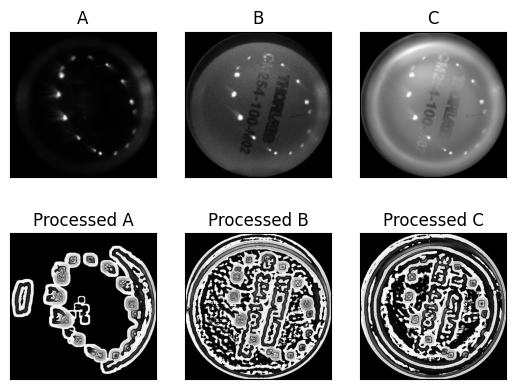

In [28]:
# clahe = cv2.createCLAHE(clipLimit=0.1)
lim = 0.0001
ksize = (15,15)
sigma = 1
t = 150
# model_dark_skewed = clahegrad(model(np.copy(skewed_dark)), lim=lim, ksize=ksize, sigma=sigma, t=t)
# model_lamp_skewed = clahegrad(model(np.copy(skewed_lamp)), lim=lim, ksize=ksize, sigma=sigma, t=t)
# model_light_skewed = clahegrad(model(np.copy(skewed_light)), lim=lim, ksize=ksize, sigma=sigma, t=t)
# model_dark_skewed = clahe.apply(model(np.copy(skewed_dark)))
# model_lamp_skewed = clahe.apply(model(np.copy(skewed_lamp)))
# model_light_skewed = clahe.apply(model(np.copy(skewed_light)))

model_dark_skewed = model(clahegrad(np.copy(skewed_dark)))
model_lamp_skewed = model(clahegrad(np.copy(skewed_lamp)))
model_light_skewed = model(clahegrad(np.copy(skewed_light)))



fig, axes = plt.subplots(2,3)
print("clahe grad")
axes[0][0].imshow(skewed_dark, cmap='gray')
axes[0][1].imshow(skewed_lamp, cmap='gray')
axes[0][2].imshow(skewed_light, cmap='gray')
axes[1][0].imshow(model_dark_skewed, cmap='gray')
axes[1][1].imshow(model_lamp_skewed, cmap='gray')
axes[1][2].imshow(model_light_skewed, cmap='gray')
axes[0][0].set_title("A")
axes[0][1].set_title("B")
axes[0][2].set_title("C")
axes[1][0].set_title("Processed A")
axes[1][1].set_title("Processed B")
axes[1][2].set_title("Processed C")

for i in range(2):
    for j in range(3):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.show()

hp


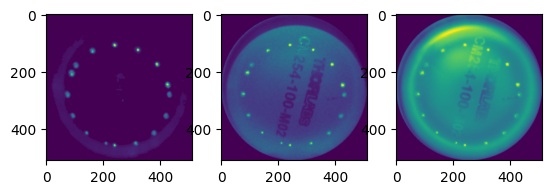

In [18]:
t = 10
hp_dark = np.copy(dark)
hp_lamp = np.copy(lamp)
hp_light = np.copy(light)
hp_dark[hp_dark<t] = 0
hp_lamp[hp_lamp<t] = 0
hp_light[hp_light<t] = 0

fig, axes = plt.subplots(1,3)
print("hp")
axes[0].imshow(hp_dark)
axes[1].imshow(hp_lamp)
axes[2].imshow(hp_light)
plt.show()

hpgrad


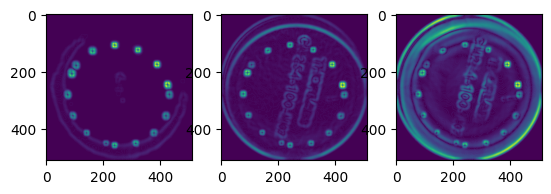

In [19]:
hpgrad_dark = grad(np.copy(hp_dark))
hpgrad_lamp = grad(np.copy(hp_lamp))
hpgrad_light = grad(np.copy(hp_light))

fig, axes = plt.subplots(1,3)
print("hpgrad")
axes[0].imshow(hpgrad_dark)
axes[1].imshow(hpgrad_lamp)
axes[2].imshow(hpgrad_light)
plt.show()

# Stopping criteria

(512, 512)


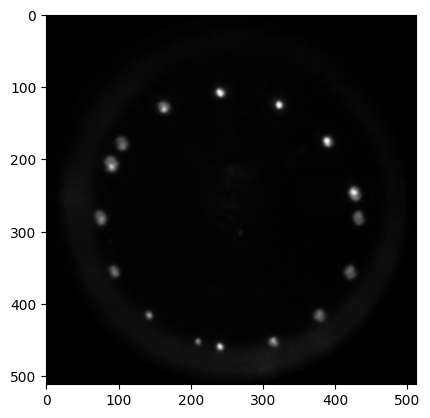

In [20]:
data_folder = "/mnt/h/latest_real_data/real_data/real"
opt_fname = "x0.00_y0.00.jpg"
img_fname = "x0.20_y0.30.jpg"
HT = 0
opt_img = cv2.imread(data_folder+"/"+opt_fname, cv2.IMREAD_GRAYSCALE)
print(opt_img.shape)
plt.imshow(opt_img, cmap="gray")

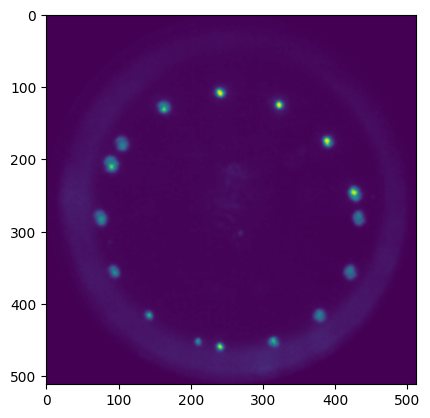

In [21]:
opt_processed = process_for_stopping_criteria(opt_img, HT)
plt.imshow(opt_processed)
plt.show()

In [22]:
def distance_from_optimum(optimum, img) -> float:
    diff = optimum - img
    diff = np.abs(diff)

    return np.sum(diff)/255

def structural_diff(optimum, img) -> float:
    return ssim(optimum, img)

In [23]:
test_img = cv2.imread(data_folder+"/"+img_fname, cv2.IMREAD_GRAYSCALE)
test_img = process_for_stopping_criteria(test_img, ht=HT)
print(distance_from_optimum(opt_img, test_img))

86628.64705882352


In [24]:
# Prepare images and x,y values

xi = -1.99
xmax = 3.69
yi = -1.99
ymax = 1.99

step = 0.2

x_vals = []
while xi < xmax:
    x_vals.append(xi)
    xi += step
    xi = round(xi, 2)

y_vals = []
while yi < ymax:
    y_vals.append(yi)
    yi += step
    yi = round(yi, 2)

fnames = [(x,y,f"x{x:.2f}_y{y:.2f}.jpg") for x in x_vals for y in y_vals]
print(len(fnames))
print(fnames[:5])



580
[(-1.99, -1.99, 'x-1.99_y-1.99.jpg'), (-1.99, -1.79, 'x-1.99_y-1.79.jpg'), (-1.99, -1.59, 'x-1.99_y-1.59.jpg'), (-1.99, -1.39, 'x-1.99_y-1.39.jpg'), (-1.99, -1.19, 'x-1.99_y-1.19.jpg')]


In [25]:
# Collect distances
def evaluate(fnames, diff_func):
    i = 0
    results = np.zeros((len(fnames), 3))
    for x, y, fname in fnames:
        # Load img
        img = cv2.imread(data_folder+"/"+fname, cv2.IMREAD_GRAYSCALE)

        # Add noize
        # img = skimage.util.random_noise(img, mode='gaussian')

        # Preprocess
        # img = process_for_stopping_criteria(img, ht=HT)

        # Calc diff
        d = diff_func(opt_img, img)

        # Rec
        results[i,0] = x
        results[i,1] = y
        results[i,2] = d

        i+= 1
    return results

In [26]:
# results = evaluate(fnames, structural_diff)


NameError: name 'results' is not defined

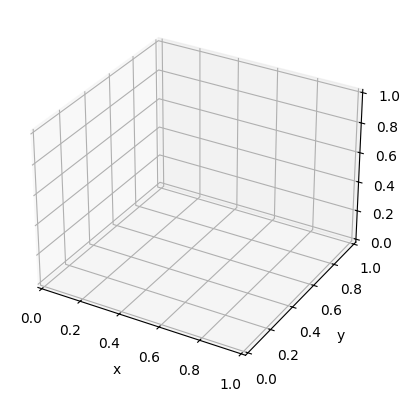

In [27]:
# display

fig = plt.figure()
ax = plt.subplot(111, projection='3d')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(results[:,0], results[:,1], results[:,2], c=results[:,2], cmap='viridis')
plt.show()

In [ ]:
xzero = np.argmin(np.abs(results[:,0]))
yzero = np.argmin(np.abs(results[xzero:xzero+50,1]))
yzero += xzero
print(xzero, yzero)
print(results[yzero])

In [ ]:
a = np.argmax(results[:,2])
print(a)
print(results[a])